# **B92 Quantum Key Distribution Protocol**

## **Overview of the B92 Quantum Key Distribution Protocol**

The B92 protocol enables two parties—**Alice** and **Bob**—to securely share a secret key using quantum states. It uses **two non-orthogonal states** to detect potential eavesdropping and ensure confidentiality.

### **Step 1: Key Preparation and Transmission**

- **Alice** generates a random bit string.
- She encodes each bit as:
  - `0` → ∣0⟩  
  - `1` → ∣+⟩ = $\frac{1}{\sqrt{2}}$(∣0⟩ + ∣1⟩)  
- The qubits are sent to **Bob** over a quantum channel.

### **Step 2: Measurement and Filtering**

- **Bob** randomly chooses a basis to measure each qubit:
  - Basis 0: detects ∣1⟩ → infers bit 0  
  - Basis 1: detects ∣−⟩ → infers bit 1  
- Only **conclusive** results are kept; inconclusive ones are discarded.

### **Step 3: Sifting and Error Checking**

- Alice and Bob use a public channel to identify positions with conclusive results and extract the **raw key**.
- They compare a random sample of bits to estimate the error rate.
- If the error rate is too high, the protocol is aborted (possible eavesdropping).

### **Step 4: Key Refinement**

- If the error rate is acceptable:
  - **Error correction** aligns their keys.
  - **Privacy amplification** (e.g., parity hashing) shortens and strengthens the key.
- The final output is a shared, secure secret key.

## **Code Implementation**

In [1]:
from classiq import *
import numpy as np

In [2]:
# B92 uses only two non-orthogonal states: |0⟩ for bit 0, |+⟩ for bit 1.

@qfunc
def b92(message: CArray[CBool], bob_bases: CArray[CBool], qba: QArray[QBit]) -> None:
    """
    Implements the quantum part of B92 protocol.
    """
    # Alice encodes: 0 -> |0⟩, 1 -> |+⟩
    repeat(message.len,
           lambda i:
           if_(message[i]==1,
               lambda: H(qba[i])
              )
          )
    
    # Bob applies measurement: 
    # He tries to detect in the state orthogonal to Alice's states.
    # If Alice sends |0⟩, Bob measures in {|1⟩} basis => Apply X before measurement.
    # If Alice sends |+⟩, Bob measures in {|−⟩} basis => Apply H, then X.

    repeat(bob_bases.len,
           lambda i:
           if_(bob_bases[i]==0,
               lambda: X(qba[i])  # Measure in {|1⟩}
              ,
               lambda:
               (H(qba[i]), X(qba[i]))  # Measure in {|−⟩}
              )
          )

# Number of qubits
SIZE = 8

np.random.seed(3)
# Alice's message: random bits {0,1}
message = np.random.randint(0, 2, SIZE).tolist()
# Bob's measurement choice: randomly pick which orthogonal basis to measure in
bob_bases = np.random.randint(0, 2, SIZE).tolist()


@qfunc
def main(qba: Output[QArray[QBit]]) -> None:
    """
    B92 protocol quantum function.
    """
    allocate(SIZE, qba)
    b92(message, bob_bases, qba)


In [3]:
# ===============================
# Quantum Model Creation
# ===============================
# Create a quantum model from the main function
qmod = create_model(main, out_file="b92_implementation")

In [4]:
# ===============================
# Set Execution Preferences
# ===============================
from classiq.execution import ExecutionPreferences

execution_preferences = ExecutionPreferences(
    num_shots=2048
)

qmod = set_execution_preferences(qmod, execution_preferences)

In [5]:
# ===============================
# Circuit Synthesis and Execution
# ===============================
# Synthesize the quantum circuit to an executable form
qprog = synthesize(qmod)

In [6]:
# Visualize the generated quantum circuit
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2z2TV4paNkuZmahkRgT8x8mudzn


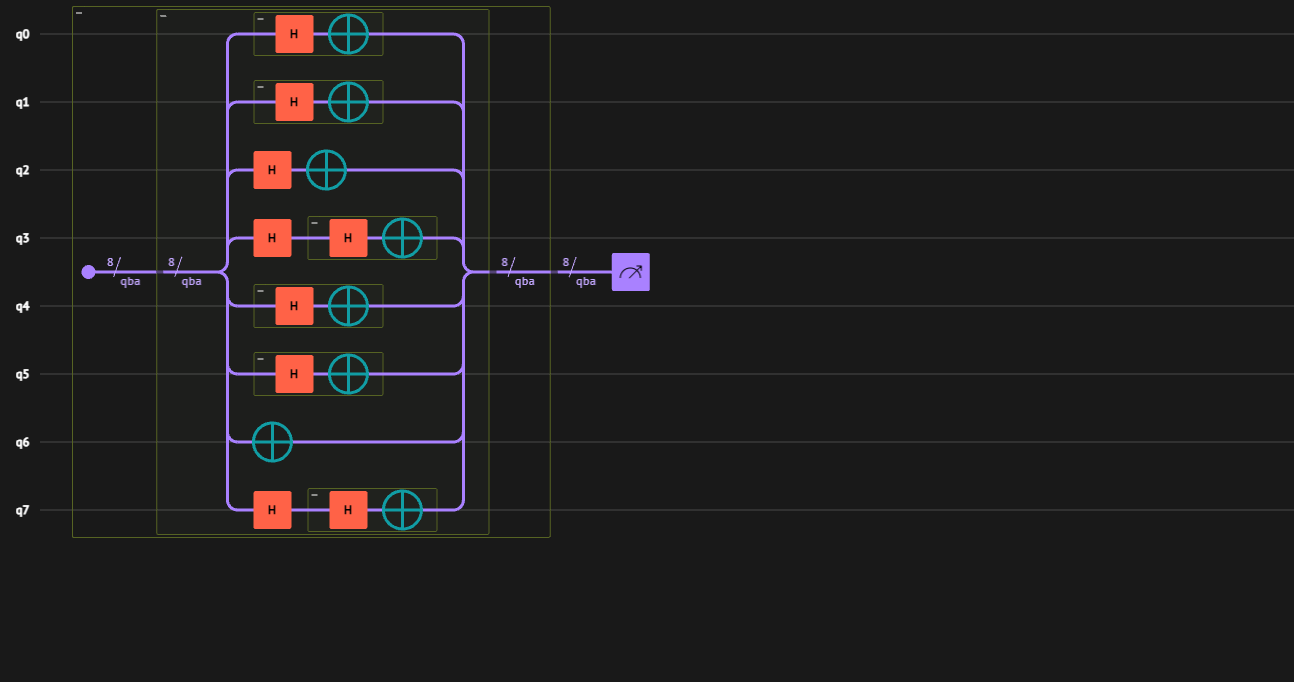

In [7]:
job = execute(qprog)

In [8]:
# ===============================
# Results Processing
# ===============================
results = job.get_sample_result().parsed_counts

## **Post-Measurement Steps in B92 Protocol**

Once Bob measures the qubits, the protocol continues with classical post-processing:

### **1. State Announcement**

- **Bob** announces the positions where he got conclusive measurements.
- **Alice** confirms which of those are valid (i.e., match the expected encoding).
- Only unambiguous results are kept for key generation.

### **2. Raw Key Sifting**

- Alice and Bob retain bits only from positions with conclusive results.
- These bits form the **raw key**.

### **3. Error Estimation**

- They compare a random subset of the raw key to estimate the **error rate**.
- A low error rate suggests the channel was secure.
- If the error rate is too high, the key is discarded and the protocol is restarted.

### **4. Error Correction**

- In practice, error-correcting codes are used to reconcile any remaining mismatches.
- In this simulation, we assume perfect correction for simplicity.

### **5. Privacy Amplification**

- A hash function is applied to the corrected key to shorten it and eliminate any partial knowledge an eavesdropper may have.
- The result is the final **secure shared key**.


In [9]:
import numpy as np

def complete_b92_protocol(measurements_list, alice_message=None, bob_bases=None):
    """
    Post-processing for the B92 protocol: extract key from measurements.

    Args:
        measurements_list: List of SampledState objects from Classiq
        alice_message: Optional[List[int]] – Alice's original message bits
        bob_bases: Optional[List[int]] – Bob's chosen measurement bases
    Returns:
        Dict containing Alice/Bob keys, error rate, and final secure key
    """

    # Constants
    SIZE = len(measurements_list[0].state['qba'])

    # Generate or validate Alice's message and Bob's bases
    alice_message = alice_message or np.random.randint(0, 2, SIZE).tolist()
    bob_bases = bob_bases or np.random.randint(0, 2, SIZE).tolist()
    if len(alice_message) != SIZE or len(bob_bases) != SIZE:
        raise ValueError("alice_message and bob_bases must be of length SIZE")

    # Extract Bob's measurement with highest shots
    try:
        best_measurement = max(measurements_list, key=lambda m: m.shots)
        bob_measurements = best_measurement.state['qba']
    except Exception:
        try:
            bob_measurements = measurements_list[0].state['qba']
        except Exception:
            raise ValueError("Failed to extract measurements from SampledState objects")

    if not isinstance(bob_measurements, list) or len(bob_measurements) != SIZE:
        raise ValueError("Invalid measurement result")

    # Filter conclusive results
    conclusive_indices = [i for i in range(SIZE) if bob_measurements[i] == 1]
    conclusive_alice = [alice_message[i] for i in conclusive_indices]
    conclusive_bob = [0 if bob_bases[i] == 0 else 1 for i in conclusive_indices]

    # Error estimation
    errors = sum(a != b for a, b in zip(conclusive_alice, conclusive_bob))
    total = len(conclusive_indices)
    error_rate = errors / total if total else 1.0

    result = {
        "alice_raw_key": conclusive_alice,
        "bob_raw_key": conclusive_bob,
        "error_rate": error_rate,
        "final_key": None
    }

    if not total:
        return result  # No conclusive results

    if error_rate < 0.15:
        # Error correction: keep only matching bits
        corrected_key = [a for a, b in zip(conclusive_alice, conclusive_bob) if a == b]

        # Privacy amplification: simple parity hash
        final_key = [corrected_key[i] ^ corrected_key[i+1] for i in range(0, len(corrected_key)-1, 2)]
        result["final_key"] = final_key
    else:
        # High error rate implies possible eavesdropping
        result["final_key"] = None

    return result

In [10]:
# ===============================
# Run the complete B92 protocol
# ===============================
b92_results = complete_b92_protocol(list(results))

print("\nFinal B92 Protocol Results:")
print(b92_results)



Final B92 Protocol Results:
{'alice_raw_key': [0, 0, 0, 1, 1, 0], 'bob_raw_key': [0, 0, 0, 0, 0, 1], 'error_rate': 0.5, 'final_key': None}


## **References**

**Note:** References [2]–[6] provide foundational background on quantum cryptography and the B92 protocol but were not all directly used in this specific implementation.

[1] **Experimental Realization of Three Quantum Key Distribution Protocols**  
[Online]. Available: [https://www.researchgate.net/publication/337670669_Experimental_Realization_of_Three_Quantum_Key_Distribution_Protocols](https://www.researchgate.net/publication/337670669_Experimental_Realization_of_Three_Quantum_Key_Distribution_Protocols)

[2] C. H. Bennett, "Quantum cryptography using any two nonorthogonal states," *Physical Review Letters*, vol. 68, no. 21, pp. 3121–3124, 1992.

[3] M. Nielsen and I. Chuang, *Quantum Computation and Quantum Information*, Cambridge University Press, 2000.

[4] N. Gisin, G. Ribordy, W. Tittel, and H. Zbinden, "Quantum cryptography," *Rev. Mod. Phys.*, vol. 74, no. 1, pp. 145–195, 2002.

[5] V. Scarani, A. Acín, G. Ribordy, and N. Gisin, "Quantum cryptography protocols robust against photon number splitting attacks for weak laser pulse implementations," *Physical Review Letters*, vol. 92, no. 5, p. 057901, 2004.

[6] S. Pirandola, U. L. Andersen, L. Banchi, et al., "Advances in quantum cryptography," *Advances in Optics and Photonics*, vol. 12, no. 4, pp. 1012–1236, 2020.
